# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
### STUDENT START ###
    print 'labels names:', newsgroups_train.target_names
    print 'file names:', len(newsgroups_train.filenames)
    print "\n----------\n"
    for i in xrange(5):
        print "LABEL: ", train_labels[i], newsgroups_train.target_names[train_labels[i]]
        print train_data[i]
        print "\n----------\n"
    
### STUDENT END ###
P1()

labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
file names: 2034

----------

LABEL:  1 comp.graphics
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

----------

LABEL:  3 talk.religion.misc


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [38]:
def P2():
### STUDENT START ###
    # Taking the Bag of Words Approach
    cv = CountVectorizer(analyzer='word')
    cv_features = cv.fit_transform(train_data)
    print "Shape of training/feature vector", cv_features.shape
    print "Non Zero Entries", cv_features.nnz
    print "[ANSWER][a1] Size of the Vocabulary", len(cv.vocabulary_)
    print '[ANSWER][a2] Average # of non-zero features per example: %.2f' % (cv_features.nnz / cv_features.shape[0])
    print '[ANSWER][a3] Sparsity: %.2f%%\n' % (100.0 * cv_features.nnz / (cv_features.shape[0] * cv_features.shape[1]))
    #print train_data[0]
    
    fn_arr = cv.get_feature_names()
    print '[ANSWER][b] 0th: {0} Last: {1}'.format(fn_arr[0], fn_arr[len(fn_arr) - 1])
    
    # Using custom vocabulary
    my_vocab = ["atheism", "graphics", "space", "religion"]
    cv = CountVectorizer(analyzer='word', vocabulary=my_vocab)
    cv_features = cv.fit_transform(train_data)
    print "Shape of training/feature vector", cv_features.shape
    print "Non Zero Entries", cv_features.nnz
    print '[ANSWER][c] Average # of non-zero features per example: %.2f\n' % (cv_features.nnz * 1.0 / cv_features.shape[0])
    
    # Taking the Bigram and Trigram character features
    cv = CountVectorizer(analyzer='char', ngram_range=(2,3))
    cv_features = cv.fit_transform(train_data)
    print "Shape of training/feature vector", cv_features.shape
    print "Non Zero Entries", cv_features.nnz
    print "[ANSWER][d] Size of the Vocabulary: {0}\n".format(len(cv.vocabulary_))
    
    # Prune Words with Doc Frequency < 10
    cv = CountVectorizer(analyzer='word', min_df=10)
    cv_features = cv.fit_transform(train_data)
    print "Shape of training/feature vector", cv_features.shape
    print "Non Zero Entries", cv_features.nnz
    print "[ANSWER][e] Size of the Vocabulary: {0}\n".format(cv_features.shape[1])
    
    # Missing Dev Data from Vocabulary
    cv = CountVectorizer()
    cv_features = cv.fit_transform(train_data)
    train_features = np.asarray(cv.get_feature_names())
    print "Shape of training/feature vector", cv_features.shape
    print "Non Zero Entries", cv_features.nnz
    cv_features_dev = cv.fit_transform(dev_data)
    print "Shape of training/feature vector", cv_features_dev.shape
    print "Non Zero Entries", cv_features_dev.nnz
    dev_features = np.asarray(cv.get_feature_names())
    #Length of Unique Dev Features not present in Train Features
    dev_features_unique = np.setdiff1d(dev_features, train_features)
    print "Unique Dev Features: {0}".format(len(dev_features_unique))
    fraction_missing = (len(dev_features_unique) * 1.0) / len(train_features)
    print "[ANSWER][f] Fraction of Dev Data missing from Vocab: {0}".format(fraction_missing)
    
### STUDENT END ###
P2()

Shape of training/feature vector (2034, 26879)
Non Zero Entries 196700
[ANSWER][a1] Size of the Vocabulary 26879
[ANSWER][a2] Average # of non-zero features per example: 96.00
[ANSWER][a3] Sparsity: 0.36%

[ANSWER][b] 0th: 00 Last: zyxel
Shape of training/feature vector (2034, 4)
Non Zero Entries 546
[ANSWER][c] Average # of non-zero features per example: 0.27

Shape of training/feature vector (2034, 35478)
Non Zero Entries 1391646
[ANSWER][d] Size of the Vocabulary: 35478

Shape of training/feature vector (2034, 3064)
Non Zero Entries 147823
[ANSWER][e] Size of the Vocabulary: 3064

Shape of training/feature vector (2034, 26879)
Non Zero Entries 196700
Shape of training/feature vector (676, 16246)
Non Zero Entries 74327
Unique Dev Features: 4027
[ANSWER][f] Fraction of Dev Data missing from Vocab: 0.14981956174


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [36]:
def P3():
### STUDENT START ###
    cv = CountVectorizer()
    X_train_counts = cv.fit_transform(train_data)
    X_dev_counts = cv.transform(dev_data)
    print "Shape of training/feature vector", X_train_counts.shape
    print "Shape of dev/feature vector", X_dev_counts.shape
 
    # K-NN
    # Tried with K from 1-1000 in steps of 20, Best: n_neighbors=181
    #nn = np.arange(1,1000,20)
    # Tried with K from 1-200 in steps of 1, Best: n_neighbors=151
    #nn = np.arange(1,200,1)
    # Best: n_neighbors=151
    nn = np.arange(1,200,10)
    parameters = {'n_neighbors': nn}
    gscv = GridSearchCV(KNeighborsClassifier(), parameters)
    gscv.fit(X_train_counts, train_labels)
    print "\n\n[KNeighborsClassifier] Grid Scores:\n {0}".format(gscv.grid_scores_)
    print "### Best Estimator ###\n {0}".format(gscv.best_estimator_)
    print "### Best Score ###\n {0}".format(gscv.best_score_)
    print "### Best Params ###\n {0}".format(gscv.best_params_)
    
    knn = KNeighborsClassifier(151)
    knn.fit(X_train_counts, train_labels)
    print "F1 Score for KNN with 151 neighbors: {0}".format(metrics.f1_score(dev_labels, knn.predict(X_dev_counts)))
    
    # Multinomial Naive Bayes model
    parameters = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    gscv = GridSearchCV(MultinomialNB(), parameters)
    gscv.fit(X_train_counts, train_labels)
    print "\n\n[MultinomialNB] Grid Scores:\n {0}".format(gscv.grid_scores_)
    print "### Best Estimator ###\n {0}".format(gscv.best_estimator_)
    print "### Best Score ###\n {0}".format(gscv.best_score_)
    print "### Best Params ###\n {0}".format(gscv.best_params_)
    
    # Multinomial Naive Bayes model
    print "\n\n[LogisticRegression]"
    c_values = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0]
    for c in c_values:
        lr = LogisticRegression(penalty="l2", C=c)
        lr.fit(X_train_counts[:1500], train_labels[:1500])
        print "\nC - {0}, Accuracy - {1}".format(c, lr.score(X_train_counts[1500:], train_labels[1500:]))
        print np.sum(lr.coef_, axis=1)

    '''
    gscv = GridSearchCV(LogisticRegression(penalty="l2"), parameters)
    gscv.fit(X_train_counts, train_labels)
    print "\n\n[LogisticRegression] Grid Scores:\n {0}".format(gscv.grid_scores_)
    print "### Best Estimator ###\n {0}".format(gscv.best_estimator_)
    print "### Best Score ###\n {0}".format(gscv.best_score_)
    print "### Best Params ###\n {0}".format(gscv.best_params_)
    '''
    
### STUDENT END ###
P3()

Shape of training/feature vector (2034, 26879)
Shape of dev/feature vector (676, 26879)


[KNeighborsClassifier] Grid Scores:
 [mean: 0.40905, std: 0.01882, params: {'n_neighbors': 1}, mean: 0.40757, std: 0.00691, params: {'n_neighbors': 11}, mean: 0.41101, std: 0.00826, params: {'n_neighbors': 21}, mean: 0.40659, std: 0.01175, params: {'n_neighbors': 31}, mean: 0.41888, std: 0.01553, params: {'n_neighbors': 41}, mean: 0.42773, std: 0.01197, params: {'n_neighbors': 51}, mean: 0.42625, std: 0.00583, params: {'n_neighbors': 61}, mean: 0.42773, std: 0.01021, params: {'n_neighbors': 71}, mean: 0.42822, std: 0.00664, params: {'n_neighbors': 81}, mean: 0.44002, std: 0.00597, params: {'n_neighbors': 91}, mean: 0.43265, std: 0.00797, params: {'n_neighbors': 101}, mean: 0.43559, std: 0.00425, params: {'n_neighbors': 111}, mean: 0.43412, std: 0.00843, params: {'n_neighbors': 121}, mean: 0.43117, std: 0.00739, params: {'n_neighbors': 131}, mean: 0.43215, std: 0.00380, params: {'n_neighbors': 141}

ANSWER:
a) Nearest Neighbor doesn't work that well due to sparsity of the feature matrix - most of the values are zero in the vocabulary
b) Logistic Regression is not as great as Naive Bayes since it is trying to separate between 1 class and the rest; further it doesn't take the priors into account.
c) As the value of C (Inverse of regularization strength) increases, the sum of coefficients (squared weight values for each class) increases. This is precisely how regularization works, and shows that more number of features are used as the C value increases. 

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [6]:
def P4():
### STUDENT START ###
    cv = CountVectorizer()
    X_train_counts = cv.fit_transform(train_data)
    print "Shape of training/feature vector", X_train_counts.shape
    print "Size of Vocabulary", len(cv.vocabulary_)
        
    lr = LogisticRegression(penalty="l2", C=0.1)
    lr.fit(X_train_counts, train_labels)
    print "Shape of coefficient weights vector", lr.coef_.shape
    
    
    # List of numpy arrays with max feature weights
    l = []
    print "\n\n5 Top Weighted Words for each Label"
    for i in xrange(len(lr.coef_)):
        x_args = np.argsort(lr.coef_[i,:])
        print "[{0}] {1}".format(newsgroups_train.target_names[i],[cv.get_feature_names()[j] for j in x_args[-5:]])
        #print lr.coef_[:, x_args[-5:]].T
        l.append(lr.coef_[:, x_args[-5:]].T)
    
    coeff_top5_1 = np.vstack(tuple(l))
    print coeff_top5_1.shape
    print coeff_top5_1
    
    # With Bigram Features
    cv = CountVectorizer(ngram_range=(2,2))
    X_train_counts = cv.fit_transform(train_data)
    
    print "\n\nShape of training/feature vector", X_train_counts.shape
    
    lr = LogisticRegression(penalty="l2", C=0.1)
    lr.fit(X_train_counts, train_labels)
    print "Shape of coefficient weights vector", lr.coef_.shape
    
     # List of numpy arrays with max feature weights
    l = []
    print "\n\n5 Top Weighted Words for each Label"
    for i in xrange(len(lr.coef_)):
        x_args = np.argsort(lr.coef_[i,:])
        print "[{0}] {1}".format(newsgroups_train.target_names[i],[cv.get_feature_names()[j] for j in x_args[-5:]])
        #print lr.coef_[:, x_args[-5:]].T
        l.append(lr.coef_[:, x_args[-5:]].T)
    
    coeff_top5_2 = np.vstack(tuple(l))
    print coeff_top5_2.shape
    print coeff_top5_2
        
### STUDENT END ###
P4()

Shape of training/feature vector (2034, 26879)
Size of Vocabulary 26879
Shape of coefficient weights vector (4, 26879)


5 Top Weighted Words for each Label
[alt.atheism] [u'islam', u'atheists', u'bobby', u'religion', u'atheism']
[comp.graphics] [u'3d', u'computer', u'file', u'image', u'graphics']
[sci.space] [u'moon', u'launch', u'nasa', u'orbit', u'space']
[talk.religion.misc] [u'fbi', u'order', u'blood', u'christians', u'christian']
(20, 4)
[[ 0.42631305 -0.08488591 -0.16506985 -0.16489325]
 [ 0.46140438 -0.07943995 -0.15838466 -0.2952738 ]
 [ 0.47809213 -0.12042167 -0.16786666 -0.22781051]
 [ 0.4938968  -0.29883217 -0.39323969  0.00389765]
 [ 0.49544551 -0.20714955 -0.19994953 -0.26778069]
 [-0.18196183  0.54713459 -0.31164659 -0.18143852]
 [-0.03971767  0.5590217  -0.32903117 -0.22868187]
 [-0.1773208   0.64123804 -0.4215729  -0.28826717]
 [-0.26357288  0.64230881 -0.36760749 -0.21614493]
 [-0.41104046  1.00762193 -0.65111663 -0.37221161]
 [-0.20273723 -0.29156992  0.40313149 -0.0

ANSWER: In the Bigram Table its counter intuitive to observe that the following features carry more weights: "in there", "out there", "in advance", and "looking for"

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [32]:
def empty_preprocessor(s):
   return s

def better_preprocessor(s):
### STUDENT START ###
    stop_words = ['i', 'a', 'about', 'an', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'how', \
                  'in', 'is', 'it', 'of', 'on', 'or', 'that', 'the', 'this', 'to', 'was', 'what', \
                  'when', 'where', 'who', 'will', 'with', 'but', 'he', 'she', 'they', 'them', 'you', 'we', 'us']
    
    suffixes = ['ing', 'ed', 'ies', 'ly', 's', 'es', 'able', 'ible', 'al', 'ial', 'en', 'er', 'est', \
                'ful', 'ic', 'ion', 'tion', 'ation', 'ition', 'ity', 'ty', 'ive', 'ative', 'itive', 'less', \
                'ment', 'ness', 'ous', 'eous', 'ious', 'y']
    
    prefixes = ['dis', 'in', 'im', 'il', 'ir', 're', 'un', 'anti', 'de', 'en', 'em', 'fore', 'inter', 'mid', \
                'mis', 'non', 'over', 'pre', 'semi', 'sub', 'super', 'trans', 'under']
    
    # Lowerr
    s = s.lower().strip()
    # Remove Stop Words, Shorten String to only 20 chars (for long words), and Remove Words <= 3 chars
    s = " ".join([w[:20] 
                  for w in s.split() if w.strip() not in stop_words and len(w.strip()) >= 3])
    # Remove special chars
    s = re.sub(r'[^a-zA-z0-9\_\s]', '', s)
    
    #Remove prefix
    prefix_regex = "|".join([prefix for prefix in prefixes])
    prefix_regex = "\\b(" + prefix_regex + ")"
    s = re.sub(prefix_regex, '', s)
    
    #Remove suffix
    suffix_regex = "|".join([suffix for suffix in suffixes])
    suffix_regex = "(" + suffix_regex + ")\\b"
    s = re.sub(suffix_regex, '', s)
    
    return s

### STUDENT END ###

def P5():
### STUDENT START ###

    cv = CountVectorizer(preprocessor=empty_preprocessor)
    X_train_counts = cv.fit_transform(train_data)
    X_dev_counts = cv.transform(dev_data)
    print "Shape of training/feature vector", X_train_counts.shape
    print "Shape of dev/feature vector", X_dev_counts.shape
    
    lr = LogisticRegression(penalty="l2", C=0.1)
    lr.fit(X_train_counts, train_labels)
    print "Shape of coefficient weights vector", lr.coef_.shape
    
    score1 = metrics.f1_score(dev_labels, lr.predict(X_dev_counts))
    print "~ With Empty Pre-Processor: ", score1
    
    cv = CountVectorizer(preprocessor=better_preprocessor)
    X_train_counts = cv.fit_transform(train_data)
    X_dev_counts = cv.transform(dev_data)
    
    lr = LogisticRegression(penalty="l2", C=0.1)
    lr.fit(X_train_counts, train_labels)
    score2 = metrics.f1_score(dev_labels, lr.predict(X_dev_counts))
    print "~ With Better Pre-Processor: ", score2
    print "# Improvement: ", (score2 - score1)
    print "# Improvement (%): ", ((score2 - score1) / score1) * 100

### STUDENT END ###
P5()

Shape of training/feature vector (2034, 33291)
Shape of dev/feature vector (676, 33291)
Shape of coefficient weights vector (4, 33291)
~ With Empty Pre-Processor:  0.701397454667
~ With Better Pre-Processor:  0.733303812391
# Improvement:  0.0319063577238
# Improvement (%):  4.54896970491


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

Shape of training/feature vector (2034, 26879)
Size of Vocabulary 26879
Shape of dev/feature vector (676, 26879)
[L1] Shape of coefficient weights vector (4, 26879)
[L2] Shape of coefficient weights vector (4, 26879)


[L1] Number of non-zero weights (1814,)
[L2] Number of non-zero weights (107516,)

[L1] C=0.005 | Number of features with at least 1 non zero weight: 11
[L2] C=0.005 | Shape of coefficient weights vector - (4, 11)
[L2] C=0.005 | Accuracy (Non Zero features) - 0.437624828038

[L1] C=0.001 | Number of features with at least 1 non zero weight: 2
[L2] C=0.001 | Shape of coefficient weights vector - (4, 2)
[L2] C=0.001 | Accuracy (Non Zero features) - 0.322508590629

[L1] C=0.01 | Number of features with at least 1 non zero weight: 17
[L2] C=0.01 | Shape of coefficient weights vector - (4, 17)
[L2] C=0.01 | Accuracy (Non Zero features) - 0.465458891499

[L1] C=0.1 | Number of features with at least 1 non zero weight: 214
[L2] C=0.1 | Shape of coefficient weights vector - (4, 

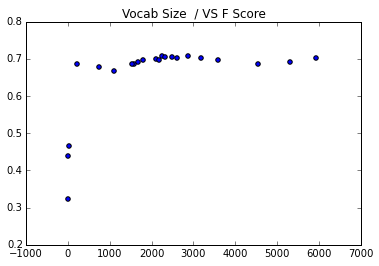

In [39]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    # This is just for testing on how to extract non zero features
    '''
    a1 = np.array([[0,10,11,0], [0,0,12,0], [0,0,0,13]])
    print a1
    print a1[a1 > 0]
    print np.nonzero(a1)
    print np.unique(np.nonzero(a1)[1])
    print a1[:, np.unique(np.nonzero(a1)[1])]
    '''

    ### STUDENT START ###
    cv = CountVectorizer()
    X_train_counts = cv.fit_transform(train_data)
    X_dev_counts = cv.transform(dev_data)
    print "Shape of training/feature vector", X_train_counts.shape
    print "Size of Vocabulary", len(cv.vocabulary_)    
    print "Shape of dev/feature vector", X_dev_counts.shape
        
    lr1 = LogisticRegression(penalty="l1", tol=0.01)
    lr1.fit(X_train_counts, train_labels)
    print "[L1] Shape of coefficient weights vector", lr1.coef_.shape
    lr1_nonzero = lr1.coef_[ (lr1.coef_ > 0) | (lr1.coef_ < 0) ]
    
    lr2 = LogisticRegression(penalty="l2", tol=0.01)
    lr2.fit(X_train_counts, train_labels)
    print "[L2] Shape of coefficient weights vector", lr2.coef_.shape
    lr2_nonzero = lr2.coef_[ (lr2.coef_ > 0) | (lr2.coef_ < 0) ]
    
    print "\n\n[L1] Number of non-zero weights", lr1_nonzero.shape
    print "[L2] Number of non-zero weights", lr2_nonzero.shape
    
    vocab_sizes = []
    f1_scores = []
    c_values = [0.005, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, \
                4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0]
    # For different values of C
    for c in c_values:
        lr1 = LogisticRegression(penalty='l1', tol=0.01, C=c)
        lr1.fit(X_train_counts, train_labels)
        # Get Features (feature indices) with atleast 1 non zero weight
        non_zero_features = np.unique(np.nonzero(lr1.coef_)[1]) 
        print "\n[L1] C={0} | Number of features with at least 1 non zero weight: {1}".format(c, len(non_zero_features))
        vocab_sizes.append(len(non_zero_features))
        
        X1_train_counts = X_train_counts[:, non_zero_features]
        X1_dev_counts = X_dev_counts[:, non_zero_features]
        
        # Train L2 Logit with pruned features
        lr2 = LogisticRegression(penalty="l2")
        lr2.fit(X1_train_counts, train_labels)
        print "[L2] C={0} | Shape of coefficient weights vector - {1}".format(c, lr2.coef_.shape)
        f1_score = metrics.f1_score(dev_labels, lr2.predict(X1_dev_counts))
        print "[L2] C={0} | Accuracy (Non Zero features) - {1}".format(c, f1_score)
        f1_scores.append(f1_score)
    
    plt.title("Vocab Size  / VS F Score")
    plt.scatter(vocab_sizes, f1_scores)
    plt.show()
    ### STUDENT END ###
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [9]:
def P7():
### STUDENT START ###
    vectorizer = TfidfVectorizer()
    tfidf_train = vectorizer.fit_transform(train_data)
    tfidf_dev = vectorizer.transform(dev_data)
    
    print "Size of train/feature vector", tfidf_train.shape
    print "Shape of dev/feature vector", tfidf_dev.shape
        
    lr = LogisticRegression(penalty="l2", C=100)
    lr.fit(tfidf_train, train_labels)
    
    pred_proba = lr.predict_proba(tfidf_dev)
    print pred_proba.shape
    print pred_proba[0], dev_labels[0]
    
    max_pred_proba = np.amax(pred_proba, axis=0)
    print max_pred_proba
    
    r_ratios = np.empty(len(dev_labels))
    for i in xrange(len(dev_labels)):
        dev_label = dev_labels[i]
        r = max_pred_proba[dev_label] / pred_proba[i][dev_label]
        r_ratios[i] = r
    #print r_ratios
    top_3_r = np.argsort(r_ratios)[-3:]
    print "Top 3 R Ratios: {0}".format(r_ratios[top_3_r])
    
    for j in top_3_r:
        print "\n\nLabel: {0}".format(newsgroups_train.target_names[dev_labels[j]])
        print dev_data[j]
    
## STUDENT END ###
P7()

Size of train/feature vector (2034, 26879)
Shape of dev/feature vector (676, 26879)
(676, 4)
[ 0.03638166  0.05409598  0.89644995  0.01307241] 2
[ 0.99624088  0.99997872  0.99977405  0.98800152]
Top 3 R Ratios: [ 327.74289654  411.50913062  924.01062349]


Label: talk.religion.misc
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.


Label: alt.atheism

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...



Label: talk.religion.misc
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been cor

ANSWER:

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.